In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import time
import math

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

c:\Users\ajwat\anaconda3\envs\python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [ ]:
writer = SummaryWriter('runs/DecisionTransformer')

### Model

In [41]:
import torch.nn.functional as F

class DecisionTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_encoder_layers, dim_feedforward, dropout=None):
        super(DecisionTransformer, self).__init__()
        self.vocab_size =  vocab_size

        # Embedding layers
        self.history_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.options_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # Encoders for history and options
        self.history_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=dim_feedforward, batch_first=True, norm_first=False, dropout=dropout, activation="relu"),
                                                     num_layers=num_encoder_layers)
        self.options_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=dim_feedforward, batch_first=True, norm_first=False, dropout=dropout, activation="relu"),
                                                     num_layers=num_encoder_layers)
        # Cross-attention layer
        self.cross_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        # Utility Decoder to map encoded features to utilities
        self.utility_decoder = nn.Linear(embed_dim, vocab_size)

    def forward(self, history_src, options_src, logit_mask):
        history_embed = self.history_embedding(history_src)
        options_embed = self.options_embedding(options_src)

        # Create masks for zero-padding
        history_pad_mask = (history_src == 0)
        options_pad_mask = (options_src == 0)

        history_embed = self.history_encoder(history_embed, src_key_padding_mask=history_pad_mask)
        options_embed = self.options_encoder(options_embed, src_key_padding_mask=options_pad_mask)

        # Cross-attention
        attn_output, attn_output_weights = self.cross_attention(
            query=options_embed,
            key=history_embed,
            value=history_embed,
            key_padding_mask=history_pad_mask,  # Prevent attention to padded areas in history
            average_attn_weights=True
        )

        # Decoding each position to utility scores
        utilities = self.utility_decoder(attn_output)

        # Apply logit mask for viable classes (setting non-viable options to very negative values)
        utilities = utilities + logit_mask

        # Mask out logits for padded tokens in options to prevent them from being selected
        utilities.masked_fill_(options_pad_mask.unsqueeze(-1), float('-inf'))

        # If needed, output probabilities for analysis or decision making, not for loss calculation
        # probabilities = F.softmax(utilities, dim=1)

        # Return utilities and token with the highest utility score in each sequence
        max_utilities, best_token_indices = torch.max(utilities, dim=1)

        return max_utilities, best_token_indices
        
    def create_mask(self, matrix, pad_token):
        return (matrix == pad_token)


### Dataset Class and Collate Function

In [17]:
import torch
from torch.utils.data import Dataset

class DecisionTransformerDataset(Dataset):
    def __init__(self, df):
        self.df = df
        # Convert necessary columns to numpy arrays for quicker access
        self.cards_in_pack = df['cards_in_pack'].to_numpy()
        self.cards_in_pool = df['cards_in_pool_no_pad'].to_numpy()
        self.card_selected = df['card_selected']
        # self.target_index = df['target_index'].to_numpy()
        self.game_wins = df['wins']
        self.max_pool_length = df.iloc[:50]['cards_in_pool_no_pad'].apply(len).max()
        self.max_pack_length = len(df['cards_in_pack'][0])
        self.vocab_size = df['card_selected'].max() + 1 + 8
        self.max_pack = len(df['cards_in_pack'][0])
        self.max_pool = df.iloc[:50]['cards_in_pool_no_pad'].apply(len).max()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # history = torch.from_numpy(self.cards_in_pool[idx])
        # options = torch.from_numpy(self.cards_in_pack[idx])
        history = self.cards_in_pool[idx]
        options = self.cards_in_pack[idx]
        target = self.card_selected[idx]
        return history, options, target
    
def add_padding(base_tensor, padded_length):
    # Create padding on CPU, and dtype should match expected input type, usually long for indices
    padded_array = np.full((1,padded_length), 0)
    padded_array[:,:len(base_tensor)] = base_tensor
    return padded_array

def make_logit_mask(indices):
    indices = torch.tensor(indices)
    # mask  = torch.full((vocab_size,), -float('inf'))
    mask  = torch.full((vocab_size,), -1000)
    mask[indices] = 0
    return mask

def decision_transformer_collate_fn(batch):
    # Unpacking the batch
    hist_srcs, options_srcs, target = zip(*batch)

    # Find the maximum length within this batch for padding
    max_hist_length = max([s.shape[0] for s in hist_srcs])
    max_option_length = max([s.shape[0] for s in options_srcs])
    max_len = max(max_hist_length, max_option_length)

    # Pad the sequences in the batch
    hist_padded = [torch.tensor(add_padding(x, max_len), dtype=torch.long) for x in hist_srcs]
    options_padded = [torch.tensor(add_padding(x, max_len), dtype=torch.long) for x in options_srcs]

    # Mask for output  logits
    logit_masks = [make_logit_mask(x) for x in options_srcs]

    # Stack the sequences
    hist_stack = torch.stack(hist_padded)
    options_stack = torch.stack(options_padded)
    mask_stack = torch.stack(logit_masks).unsqueeze(1)
    target_stack = torch.tensor(target).unsqueeze(1)
    target_indices = torch.where(options_stack.squeeze() == target_stack)[1]
    
    return hist_stack, options_stack, mask_stack, target_stack, target_indices



### Training Loop Functions

In [4]:

def train_loop(model, optimizer, loss_fn, dataloader, device, epoch, max_pool, scheduler=None, loss_fn_2=None, loss_scaling=False, batch_steps=None):
    model.train()
    total_train_loss = 0

    for i, batch in enumerate(dataloader):

        history_src, options_src, logit_mask, target, target_indices = [x.to(device) for x in batch] 

        # Get logits from forward pass
        logits, top_tokens = model(history_src.squeeze(), options_src.squeeze(), logit_mask)

        # Record loss
        loss = loss_fn(logits, target_indices.view(-1))        
        total_train_loss += loss.item()
        
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
        writer.add_scalar('LearningRate/lr', optimizer.param_groups[0]['lr'], epoch * len(dataloader) + i)

        optimizer.zero_grad()
        loss.backward()
        # Advance Optimizer and LR Scheduler
        optimizer.step()
        scheduler(None)

        # if loss_scaling:
        #     # Scaling factor
        #     scale_factor = 2**4
        #     # Scale up the loss
        #     scaled_loss = loss * scale_factor
        #     # Backward pass on the scaled loss
        #     scaled_loss.backward()
        #     # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        #     # Scale down gradients
        #     for param in model.parameters():
        #         if param.grad is not None:
        #             param.grad /= scale_factor
        # else:
        #     optimizer.zero_grad()
        #     loss.backward()
        #     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

        # Record gradients to tensorboard
        if i % 10 == 0:
          for name, parameter in model.named_parameters():
              # writer.add_histogram(f'{name}', parameter, epoch * len(dataloader) + i)
              if parameter.grad is not None:
                  writer.add_scalar(f'Gradients/{name}', parameter.grad.norm(), epoch * len(dataloader) + i)
                  writer.add_histogram(f'{name}/grads', parameter.grad, epoch * len(dataloader) + i)

        if i % 100 == 0:
            print(f"Batch {i} of {batch_steps}, Loss {loss.item():.4f}") # , LR  {optimizer.param_groups[0]['lr']:.4f}

        if i >= batch_steps:
            break

    average_train_loss = total_train_loss / batch_steps
    return average_train_loss


def validate_loop(model, loss_fn, dataloader, device, epoch, max_pool):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_predictions = 0
    correct_top_2 = 0
    correct_top_3 = 0
    total_predictions = 0

    with torch.no_grad():  # No gradient computation for validation
        for batch in dataloader:
            history_src, options_src, logit_mask, target, target_indices = [x.to(device) for x in batch] 
            # Get logits from forward pass
            logits, top_tokens = model(history_src.squeeze(), options_src.squeeze(), logit_mask)
            # Record loss
            loss = loss_fn(logits, target_indices.view(-1))
            total_val_loss += loss.item()

            # Calculate accuracy
            _, predicted_indices = torch.max(logits, dim=-1)
            _, pred_top_2 = torch.topk(logits, 2)
            _, pred_top_3 = torch.topk(logits, 3)
            correct_predictions += (predicted_indices == target_indices).sum().item()
            correct_top_2 += (target_indices.unsqueeze(1) == pred_top_2).any(dim=1).sum().item()
            correct_top_3 += (target_indices.unsqueeze(1) == pred_top_3).any(dim=1).sum().item()
            total_predictions += target_indices.numel()

    average_loss = total_val_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    top_2_accuracy = correct_top_2 / total_predictions
    top_3_accuracy = correct_top_3 / total_predictions

    # Log loss
    writer.add_scalar('Loss/val', average_loss, epoch)
    writer.add_scalar('Accuracy/val', accuracy, epoch)
    writer.add_scalar('Accuracy/top2', top_2_accuracy, epoch)
    writer.add_scalar('Accuracy/top3', top_3_accuracy, epoch)

    return average_loss, accuracy, top_2_accuracy, top_3_accuracy



def fit(model, optimizer, loss_fn, train_dataloader, val_dataloader, device, epochs, max_pool, scheduler=None, save_path='best_model.pth', loss_fn_2=None, loss_scaling=False, batch_steps=None):

    training_losses = []
    validation_losses = []
    validation_accuracies = []
    validation_accuracies_2 = []
    validation_accuracies_3 = []
    fit_times = []
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity

    for epoch in range(epochs):

        epoch_start_time = time.time()
        print(f'\nEpoch {epoch+1}')
        print('--------------------')
        # Training Phase
        train_loss = train_loop(model, optimizer, loss_fn, train_dataloader, device, epoch, max_pool, scheduler, loss_fn_2, loss_scaling, batch_steps)
        training_losses.append(train_loss)

        # Validation Phase
        val_loss, val_accuracy, val_top_2, val_top_3 = validate_loop(model, loss_fn, val_dataloader, device, epoch, max_pool)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)
        validation_accuracies_2.append(val_top_2)
        validation_accuracies_3.append(val_top_3)

        # Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, save_path)
            print(f"Checkpoint saved")

        epoch_duration = (time.time() - epoch_start_time)
        fit_times.append(epoch_duration)
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Training Loss: {train_loss:.4f}")
        print(f"  Validation Loss: {val_loss:.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.4f}")
        print(f"       Top 2 Accuracy: {val_top_2:.4f}")
        print(f"       Top 3 Accuracy: {val_top_3:.4f}")
        print(f"  Training Time: {epoch_duration:5.2f}s")

    # Close the writer
    writer.close()
    print(f"Total Training Time: {sum(fit_times):5.2f}s")
    return training_losses, validation_losses, validation_accuracies, validation_accuracies_2, validation_accuracies_3, fit_times

### Load and Format Data

In [10]:
SET_NAME = 'SIR'

# filename = f'{SET_NAME}_all_wins.parquet.gz'
filename = f'{SET_NAME}_no_pad.parquet'

data = pd.read_parquet(filename)
vocab_size = data['card_selected'].max() + 1 + 8
max_pack = len(data['cards_in_pack'][0])
max_pool = len(data['cards_in_pool'][0]) + 2 # Add back 2 to max pool to account for the final 2 picks that were excluded from training
max_pool = data.iloc[:50]['current_pool_with_wins'].apply(len).max()

# data = data.sample(100000).reset_index(drop=True)

print('max_pool:', max_pool)
print('max_pack:', max_pack)

max_pool: 44
max_pack: 15


In [19]:
def strip_padding(sequence):
    unpadded_len = len(sequence.nonzero()[0])
    return sequence[:unpadded_len]

data['cards_in_pool_no_pad'] = data.apply(lambda x: strip_padding(x['cards_in_pool']), axis=1)

In [12]:
def fix_empty_sequences(sequence):
    if len(sequence) == 0:
        sequence = np.array([1], dtype='int64')
    return sequence
              
data['cards_in_pool'] = data.apply(lambda x: fix_empty_sequences(x['cards_in_pool']), axis=1)

In [22]:
from sklearn.model_selection import train_test_split

ds_train, ds_val = train_test_split(data, test_size=0.2, shuffle=True)
ds_train = ds_train.reset_index(drop=True)
ds_val = ds_val.reset_index(drop=True)

print(f'Training Size: {len(ds_train):,}\nValidation size: {len(ds_val):,}')

Training Size: 16,139
Validation size: 4,035


In [20]:
data

,draft_id,cards_in_pool,current_pool_with_wins,cards_in_pack,card_selected,wins,cards_in_pool_no_pad
0,007aecc3d69344a5ae2c65f85267d0a7,[1],[362],"[317, 212, 276, 83, 286, 36, 86, 22, 225, 132,...",40,3,[1]
1,007aecc3d69344a5ae2c65f85267d0a7,[40],"[362, 40]","[321, 264, 186, 296, 154, 188, 127, 71, 24, 22...",96,3,[40]
2,007aecc3d69344a5ae2c65f85267d0a7,"[40, 96]","[362, 40, 96]","[214, 119, 21, 191, 196, 62, 356, 165, 39, 33,...",39,3,"[40, 96]"
3,007aecc3d69344a5ae2c65f85267d0a7,"[40, 96, 39]","[362, 40, 96, 39]","[213, 188, 189, 87, 69, 220, 133, 24, 282, 104...",282,3,"[40, 96, 39]"
4,007aecc3d69344a5ae2c65f85267d0a7,"[40, 96, 39, 282]","[362, 40, 96, 39, 282]","[151, 186, 220, 311, 225, 196, 314, 207, 142, ...",142,3,"[40, 96, 39, 282]"
...,...,...,...,...,...,...,...
20169,fed41272da0d48fba2c04fdb88999b74,"[144, 50, 31, 72, 119, 187, 31, 127, 17, 17, 1...","[361, 144, 50, 31, 72, 119, 187, 31, 127, 17, ...","[286, 125, 156, 95, 229, 105]",125,2,"[144, 50, 31, 72, 119, 187, 31, 127, 17, 17, 1..."
20170,fed41272da0d48fba2c04fdb88999b74,"[144, 50, 31, 72, 119, 187, 31, 127, 17, 17, 1...","[361, 144, 50, 31, 72, 119, 187, 31, 127, 17, ...","[214, 32, 296, 127, 173]",296,2,"[144, 50, 31, 72, 119, 187, 31, 127, 17, 17, 1..."
20171,fed41272da0d48fba2c04fdb88999b74,"[144, 50, 31, 72, 119, 187, 31, 127, 17, 17, 1...","[361, 144, 50, 31, 72, 119, 187, 31, 127, 17, ...","[157, 160, 267, 26]",26,2,"[144, 50, 31, 72, 119, 187, 31, 127, 17, 17, 1..."
20172,fed41272da0d48fba2c04fdb88999b74,"[144, 50, 31, 72, 119, 187, 31, 127, 17, 17, 1...","[361, 144, 50, 31, 72, 119, 187, 31, 127, 17, ...","[46, 239, 274]",274,2,"[144, 50, 31, 72, 119, 187, 31, 127, 17, 17, 1..."


### Instantiate Model and DataLoader

In [42]:
# Parameters
vocab_size = vocab_size
embed_dim = 256
num_heads = 2
num_encoder_layers = 2
dim_feedforward = 512
pad_token_id = 0
batch_size = 32


# Instantiate model
model = DecisionTransformer(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

from torch.utils.data import DataLoader
dataset = DecisionTransformerDataset(ds_train)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=decision_transformer_collate_fn,
    pin_memory=False
)

val_dataset = DecisionTransformerDataset(ds_val)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=decision_transformer_collate_fn,
    pin_memory=False
)

n_batches = len(dataset) // batch_size


In [ ]:
num_epochs=8
steps_per_epoch = 2000
total_iteration = steps_per_epoch * num_epochs

initial_lr = 3e-4
warmup_initial_lr = 1e-7
warmup_iteration = 2*steps_per_epoch

opt = torch.optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = nn.CrossEntropyLoss()

scheduler = create_lr_scheduler_with_warmup(StepLR(opt, step_size=(total_iteration // (num_epochs)), gamma=0.5),
                                               warmup_start_value=warmup_initial_lr,
                                               warmup_duration=warmup_iteration,
                                               warmup_end_value=initial_lr)
scheduler(None)


### Fit the Model

In [ ]:
writer = SummaryWriter('runs/DecisionTransformer/Fit_1')

n_epochs = 4

save_path = f'DecisionTransformer_{SET_NAME}_{embed_dim}dim_{num_encoder_layers}layers_{num_heads}heads_{n_epochs}epochs.pth'

print(save_path)

print(f'Embedding dim: {embed_dim} | Heads: {num_heads} | Encoder Layers: {num_encoder_layers} | Opt: AdamW | LR: {initial_lr}\n')

training_results = fit(model, opt, loss_fn, dataloader, val_dataloader, device, n_epochs, max_pool, scheduler=scheduler,
                       save_path=save_path)


In [32]:
for batch in dataloader:
    break

history_src, options_src, logit_mask, target, target_indices = [x.to(device) for x in batch] 

# Get logits from forward pass
logits, top_tokens = model(history_src.squeeze(), options_src.squeeze(), logit_mask)

### Torchview

In [28]:
from torchview import draw_graph
import graphviz


graphviz.set_jupyter_format('png')

'png'


(dot.exe:7384): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


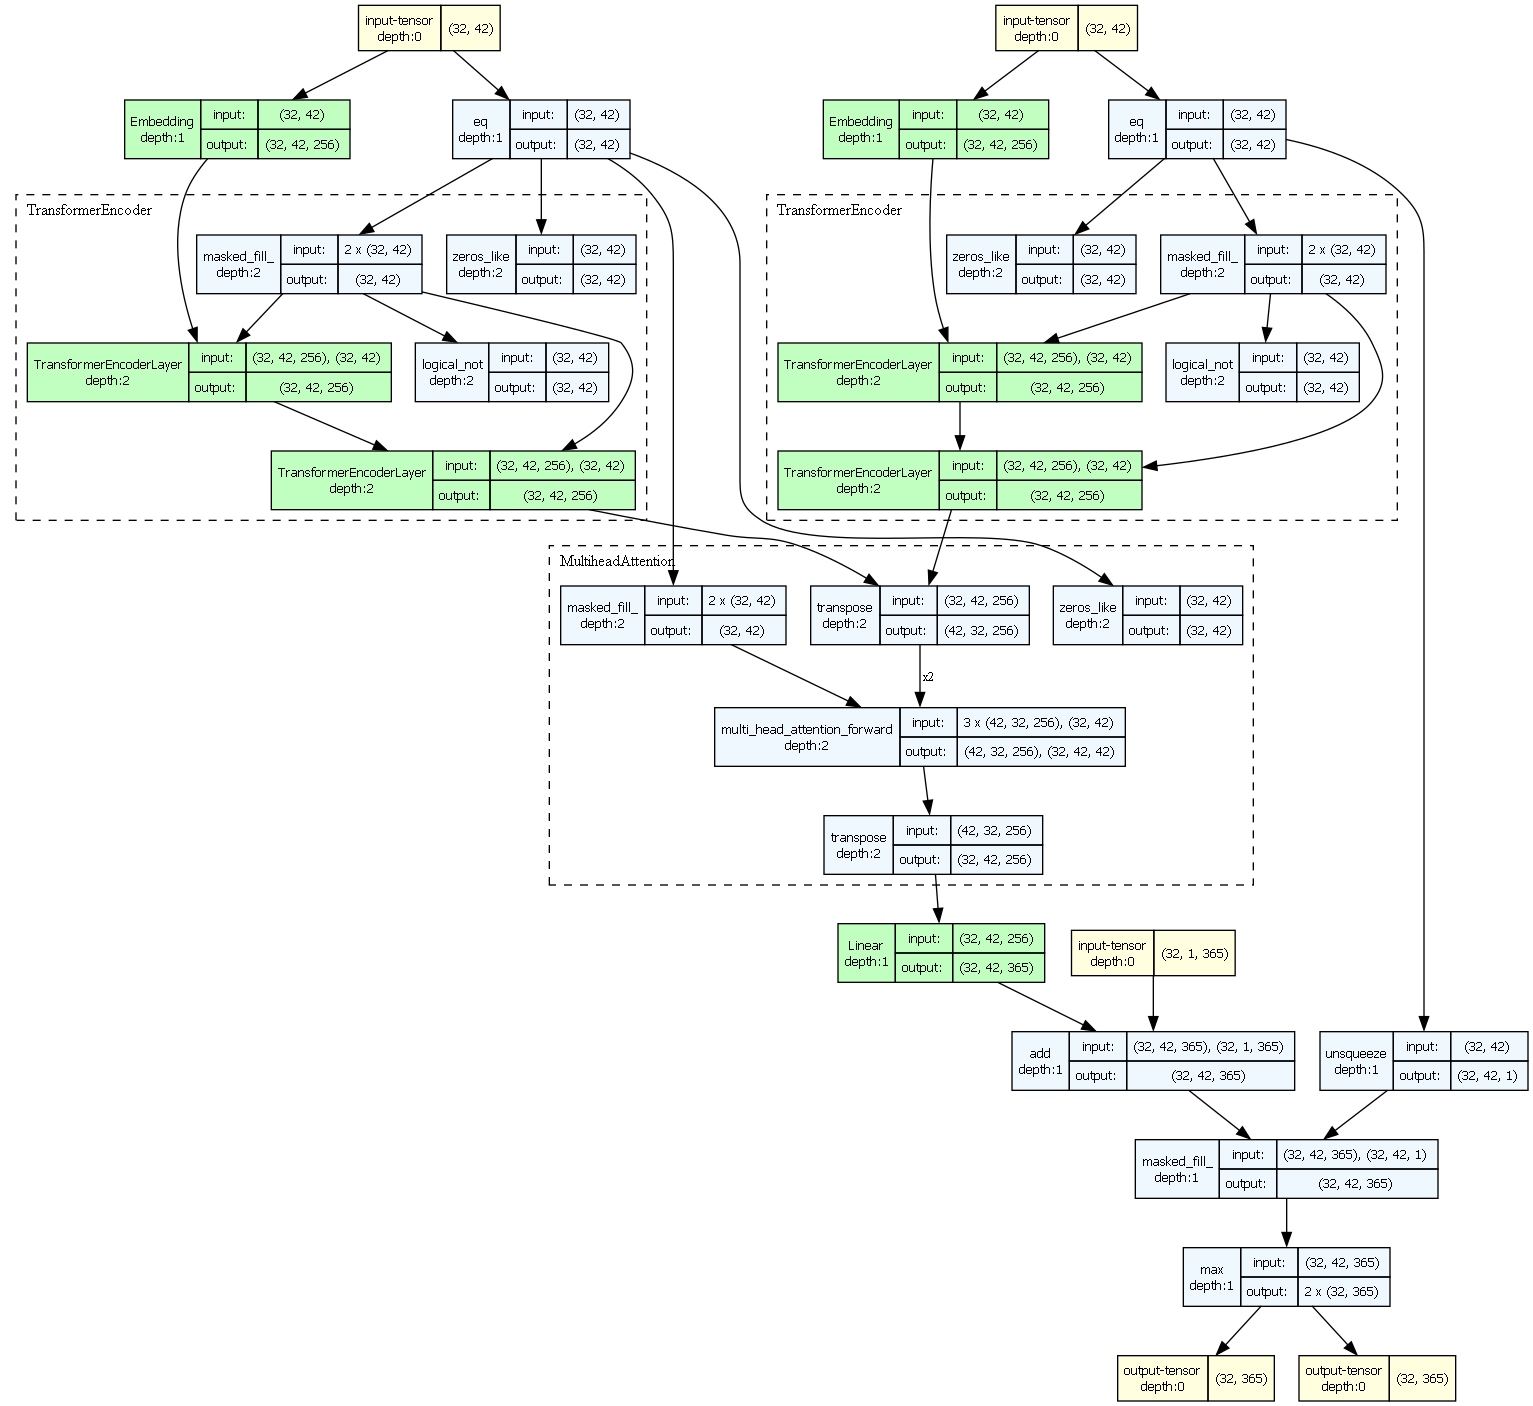

In [43]:
model_graph_1 = draw_graph(model,
    input_data=([history_src.squeeze(), options_src.squeeze(), logit_mask]),
    graph_name='DecisionTransformer',
    roll=True,
    expand_nested=True,
    hide_module_functions=True,
    depth=2,
    hide_inner_tensors=True,
    graph_dir='TB'
)
model_graph_1.resize_graph(scale=1.5)

model_graph_1.visual_graph